In [ ]:
!pip install kaggle
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/.
!rm -f /content/Walmart.csv
!kaggle datasets download -d yasserh/walmart-dataset
!unzip \*.zip  && rm *.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/122k [00:00<?, ?B/s]
100% 122k/122k [00:00<00:00, 42.2MB/s]
Archive:  walmart-dataset.zip
  inflating: Walmart.csv             


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# Importing the dataset

df = pd.read_csv('/content/Walmart.csv')

display(df.head())

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Inference: The Datset consists of 8 features & 6435 samples.


# Data Exploration #1

In [ ]:
# Reframing the columns

df.Date=pd.to_datetime(df.Date)

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

df.drop(['Date'], axis=1, inplace=True)

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [ ]:
# Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [ ]:
# Checking number of unique rows in each feature

df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

***Types of features -*** 
1. **Categorical features** - Refers to a data type that can be stored and identified based on the names or labels given to them (i.e.- features are discrete)
2. **Numeric features** - Refers to the data that is in the form of numbers, and not in any language or descriptive form (i.e.- features are not labeled).

In [ ]:
# Exploring the types of features - categorical & numeric features

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; 

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [ ]:
#Checking the stats of all the columns

display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


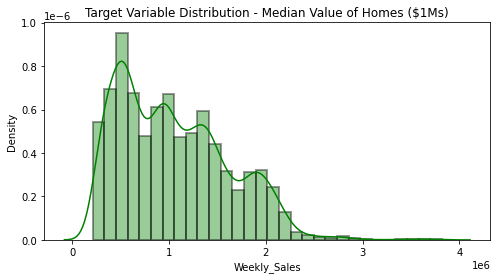

In [ ]:
# Distribution of the target variable - Weekly_Sales

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


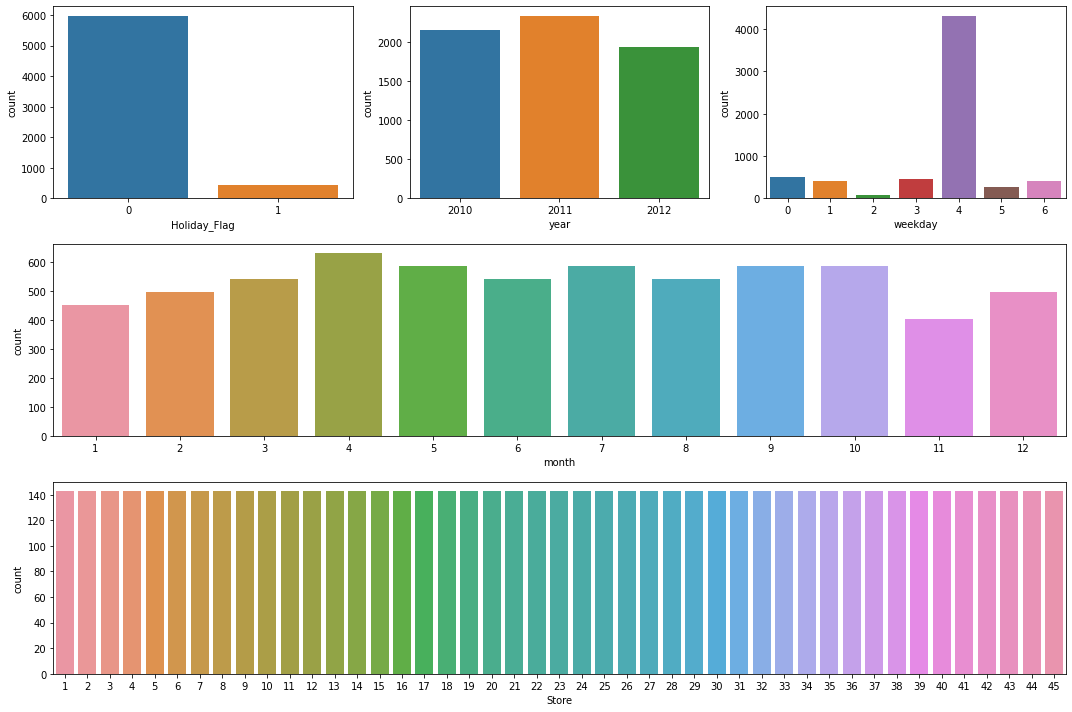

In [ ]:
# Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

plt.figure(figsize=[15,10])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(3,3,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

### ***Interpreting a Distance Plot***
![distplot.png](https://seaborn.pydata.org/_images/seaborn-distplot-2.png)

### ***Interpreting a Box Plot***
![boxplot.png](https://miro.medium.com/max/1838/1*2c21SkzJMf3frPXPAR_gZA.png)


                                                Numeric Features Distribution                                                 


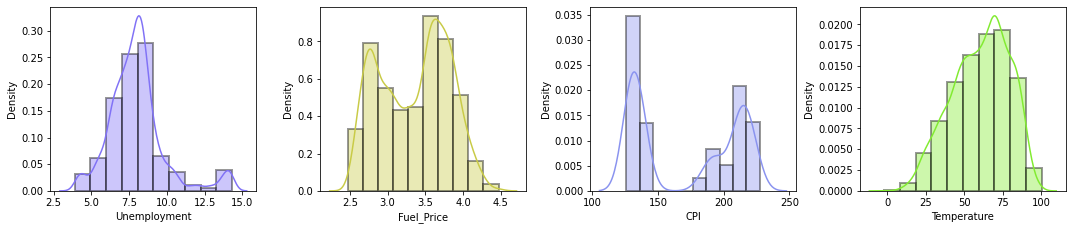

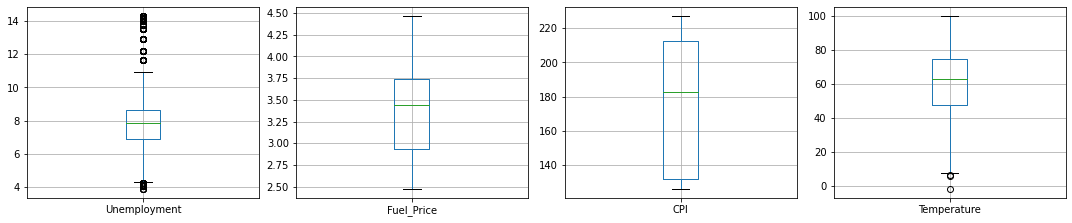

In [ ]:
# Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(130))

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

# Data Cleansing #1

In [ ]:
# Removal of any Duplicate rows (if any)

rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [ ]:
# Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


# Data Transformation #1

**Label Encoding** - Converting non-numeric (categorical) values into machine-readable values.
1. ***One-Hot Binary Encoding***

>![1hotencode.png](https://miro.medium.com/max/1278/1*lS-1YL8UfhcSFnZ5weIMdg.png)

2. ***Dummy Encoding***

>![dummyencode.png](https://miro.medium.com/max/1078/1*GlKVmFiao1DUFaxxu6Zucw.png)

*Although Dummy encoding  and One-hot encoding are similar, Dummy encoding creates ***N-1*** new columns instead of ***N*** (for OHE). In this way, we reduce some of the sparse classes.*

In [ ]:
# Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

oh=True
dm=True
for i in fcc:
    if df3[i].nunique()==2: # One-Hot Binary Encoding
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2): # Dummy Encoding
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        # Dummy drops first columns as it creates N-1 columns. Alternatively, we can use one-hot encoding.
df3.shape

One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
weekday
month
Store


(6435, 69)

# Data Cleansing #2

In [ ]:
# Removing the outliers as seen in the boxplots

df1 = df3.copy()

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)

display(df1.head())

print('\n\033[1mInference:\033[0m\nBefore removing outliers, the dataset had {} samples.'.format(df3.shape[0]))
print('After removing the outliers, the dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Inference:
Before removing outliers, the dataset had 6435 samples.
After removing the outliers, the dataset now has 5953 samples.


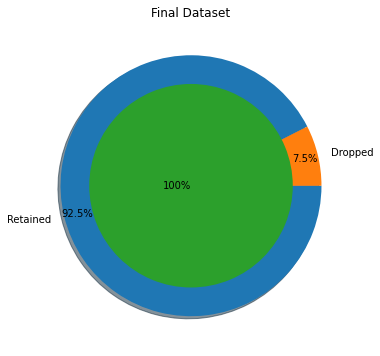


Inference: After the cleanup process, 482 samples were dropped, while retaining 92.51% of the data.


In [ ]:
# Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round((df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [ ]:
# Splitting the data into training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 68) (5953,) 
Training set  --->  (4762, 68) (4762,) 
Testing set   --->  (1191, 68)  (1191,)


# Data Transformation #2

**Scaling the data** - Feature scaling is a method used to normalize the range of independent variables or features of data.

![scale2.jpg](https://miro.medium.com/max/1750/1*bssNfrg7qHX_flK_6k2uFA.png)

<br>

1. ***Normalization*** - A scaling technique in which values are shifted and rescaled to a range between 0 and 1. It is also known as **Min-Max scaling**.

>![scale1.jpg](https://media.geeksforgeeks.org/wp-content/uploads/min-max-normalisation.jpg)

2. ***Standardization*** - A scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation. 

>![scale.jpg](https://media.geeksforgeeks.org/wp-content/uploads/standardisation.jpg)

In [ ]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-1.741339e-16,-1.494674e-16,-3.084005e-16,-2.673441e-16,-4.298675e-16,3.964583e-16,3.839385e-16,-3.934507e-16,1.890317e-16,3.962484e-16,-3.381028e-16,-2.412893e-15,5.084364e-16,7.462415e-16,-5.871686e-16,-2.337017e-16,-4.578912e-17,5.078303e-16,1.135589e-15,6.182930e-17,4.837467e-16,-2.889797e-16,3.154996e-16,4.119622e-16,4.649671e-16,-3.352002e-16,3.003920e-16,-3.142407e-16,-5.098936e-16,-2.283441e-15,-8.749826e-17,7.090203e-16,1.055551e-16,-1.274029e-15,-1.580820e-16,2.914743e-16,-5.234042e-16,-2.658637e-16,-5.230311e-16,8.578466e-17,-5.998748e-16,-3.312950e-16,-4.324904e-16,1.060750e-15,-2.839555e-16,-2.130103e-16,-5.585620e-16,9.775651e-17,-5.075505e-16,-9.160156e-17,-2.098950e-16,1.096934e-16,3.063255e-16,2.747231e-16,1.570096e-16,-2.626230e-16,4.759714e-16,3.112098e-16,-4.515031e-16,-6.241216e-16,-1.086772e-15,-6.947287e-16,-2.611192e-17,3.944649e-16,-1.004738e-15,5.259687e-16,6.589880e-16,6.687683e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.742012e-01,-2.961575e+00,-1.871814e+00,-1.248731e+00,-2.762670e+00,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,-1.424522e+00,-2.137151e-01,-2.629664e-01,-2.846827e-01,-3.011659e-01,-3.320875e-01,-3.194679e-01,-2.986704e-01,-3.186689e-01,-2.982532e-01,-3.162643e-01,-3.262095e-01,-2.560523e-01,-2.885438e-01,-1.537717e-01,-1.544857e-01,-1.479473e-01,-1.486867e-01,-1.580118e-01,-1.573123e-01,-1.607822e-01,-1.472045e-01,-1.537717e-01,-1.573123e-01,-5.621290e-02,-1.544857e-01,-1.544857e-01,-1.580118e-01,-1.587085e-01,-1.566100e-01,-1.587085e-01,-1.559048e-01,-1.544857e-01,-1.559048e-01,-1.594024e-01,-1.348111e-01,-1.544857e-01,-1.621515e-01,-1.587


                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.005646,0.044406,0.075113,0.021041,-0.050953,0.052984,0.065042,0.007679,0.038532,0.026409,0.007437,-0.037063,-0.024006,0.030967,0.002914,-0.034527,-0.026926,0.019778,-0.008115,0.048158,0.007898,-0.081299,0.033960,0.014064,0.030677,0.023585,-0.008761,0.082186,-0.010959,-0.009638,-0.037568,0.097548,0.030677,-0.004168,-0.026245,0.023585,0.023585,-0.010959,-0.017693,0.002681,-0.017693,0.009588,0.023585,0.009588,-0.024372,-0.039690,0.023585,-0.050553,-0.017693,-0.037568,0.012047,-0.050553,-0.063336,0.030677,-0.030997,0.002681,0.002681,0.016556,-0.004168,-0.017693,0.111140,-0.010959,-0.000055,0.030677,-0.004168,-0.056970,0.016556,0.045053
std,1.009885,1.000220,0.971917,1.004644,1.010206,1.014188,1.028250,1.014142,1.152364,1.044095,0.997701,0.913139,0.956668,1.048774,1.004808,0.952400,0.961441,1.029957,0.988876,1.070395,1.011569,0.878257,1.060059,1.022429,1.093088,1.072117,0.970975,1.238976,0.965939,0.970025,0.878420,1.280691,1.093088,0.987401,0.730989,1.072117,1.072117,0.965939,0.944330,1.008734,0.944330,1.029954,1.072117,1.029954,0.922555,0.842590,1.072117,0.833343,0.944330,0.878420,1.109284,0.833343,0.787090,1.093088,0.900592,1.008734,1.008734,1.051077,0.987401,0.944330,1.881448,0.965939,1.000214,1.093088,0.987401,0.810380,1.051077,1.134875
min,-0.274201,-2.857425,-1.780457,-1.248731,-2.762670,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,-1.424522,-0.213715,-0.262966,-0.284683,-0.301166,-0.332088,-0.319468,-0.298670,-0.318669,-0.298253,-0.316264,-0.326210,-0.256052,-0.288544,-0.153772,-0.154486,-0.147947,-0.148687,-0.158012,-0.157312,-0.160782,-0.147205,-0.153772,-0.157312,-0.056213,-0.154486,-0.154486,-0.158012,-0.158708,-0.156610,-0.158708,-0.155905,-0.154486,-0.155905,-0.159402,-0.134811,-0.154486,-0.162151,-0.158708,-0.160782,-0.052320,-0.162151,-0.163510,-0.153772,-0.160094,-0.156610,-0.156610,-0.155197,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
25%,-0.274201,-0.657516,-0.852751,-1.077025,-0.699355,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,-1.424522,-0.213715,-0.262966,-0.284683,-0.301166,-0.332088,-0.319468,-0.298670,-0.318669,-0.298253,-0.316264,-0.326210,-0.256052,-0.288544,-0.153772,-0.154486,-0.147947,-0.148687,-0.158012,-0.157312,-0.160782,-0.147205,-0.153772,-0.157312,-0.056213,-0.154486,-0.154486,-0.158012,-0.158708,-0.156610,-0.158708,-0.155905,-0.154486,-0.155905,-0.159402,-0.134811,-0.154486,-0.162151,-0.158708,-0.160782,-0.052320,-0.162151,-0.163510,-0.153772,-0.160094,-0.156610,-0.156610,-0.155197,-0.157312,-0.158708,-0.043515,-0.1

***Correlation between features***

Correlation is a statistical term describing the degree to which two variables move in coordination with one another. 
- Higher correlation means a change in one feature would signify an almost equally significant change in another feature.
- e.g. - A temperature drop leads to an increase in the sale of winterwear.
- Year & Age have a linear correlation, with a value of 1. i.e.- If year increases by 1, age will also increase by the same amount. This implies that one feature is causing the changes in the other feature.
- Correlaton can be -1, when an increase in one feature would imply an equally significant decrease in another feature.

---

>A high correlation (1 or -1) would help in analyzing how inter-dependent two features are and hence, deduce their significance in the knowledge gained. However, in training an ML algorithm, this is not always advantageous as it introduces the **Curse of Dimensionality** 

>***Curse of Dimensionality*** - More input variables (high dimensional data) leading to poor generalzation of the data, and subsequent overfitting on input data.

><img src="https://miro.medium.com/max/1688/1*Y_zH9azBxlKaDHVdpEAPqw.jpeg" alt="drawing" height="200"/> 
<img src="https://miro.medium.com/max/1750/1*1IKmBxXHmRIwg5YhTYXz0w.jpeg" alt="drawing" height="200"/>
<img src="https://miro.medium.com/max/1750/1*XnxwQKGgnHiMtnoVgpkkww.jpeg" alt="drawing" height="200"/>

>A low correlation (= 0) is advanageous while training an ML algorithm because one feature does not affect the impact of a different feature (independent fetures) on the model. This way the model learns fair amount of information from all features.

                                       Correlation Matrix                                       


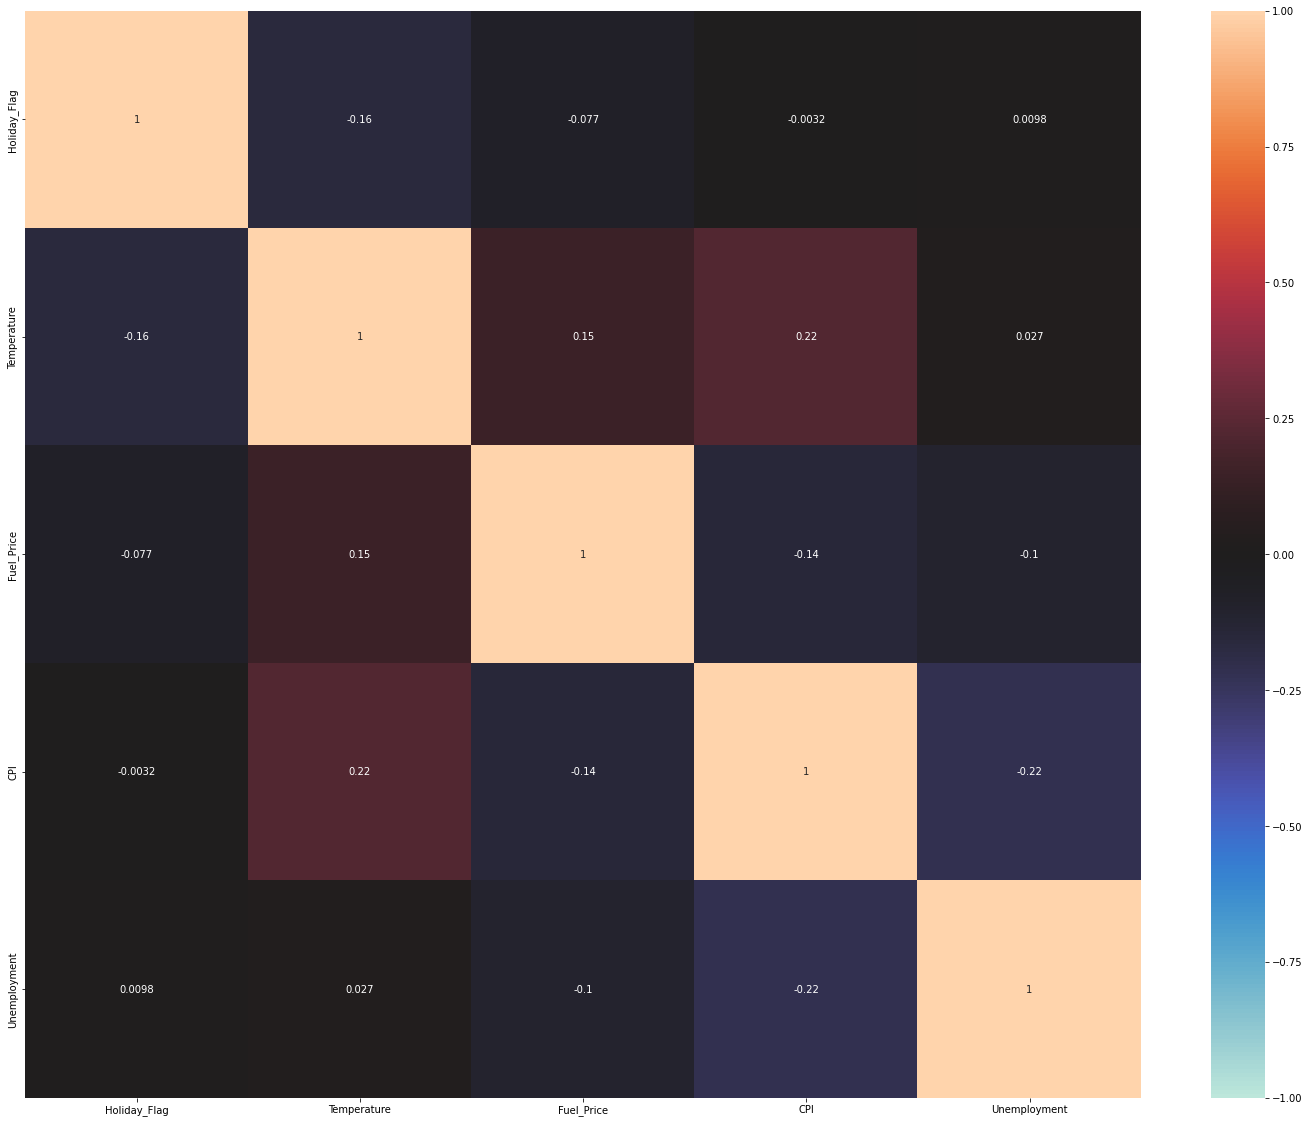

In [ ]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df[['Holiday_Flag',	'Temperature',	'Fuel_Price',	'CPI',	'Unemployment']].corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

# Testing a simple Linear Regression Model

In [ ]:
# Creating a function to evaluate the algorithm's performance

rc=Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values

def Evaluate(n, pred1,pred2):
    # Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,8])
    for e,i in enumerate(rc):
        plt.subplot(2,2,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual ('+i+')')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction ('+i+')')
        plt.legend()
    plt.show()

    # Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Testing set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Testing set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Testing set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regression Model was found to be  1047603.298112138


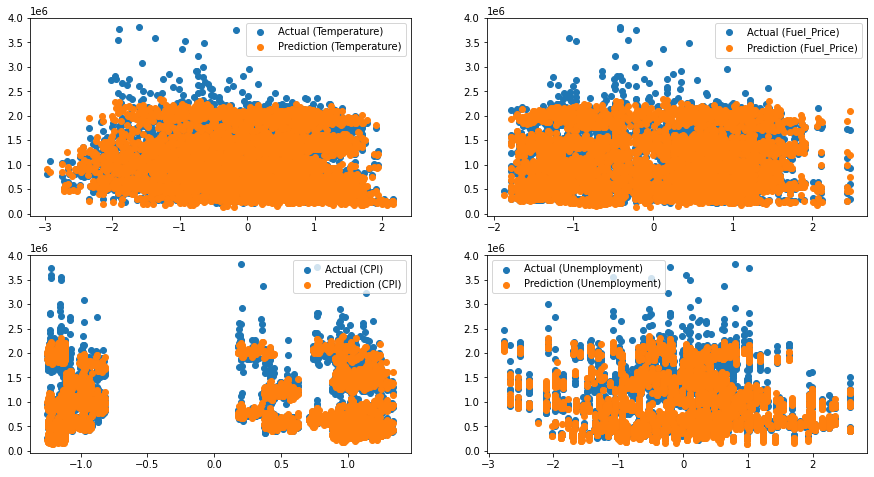



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9328296106281632
Residual Sum of Squares (RSS) on Training set  ---> 103518718391842.16
Mean Squared Error (MSE) on Training set       ---> 21738496092.365005
Root Mean Squared Error (RMSE) on Training set ---> 147439.80497940507

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9303017696577067
Residual Sum of Squares (RSS) on Testing set  ---> 28393614754891.715
Mean Squared Error (MSE) on Testing set       ---> 23840146729.54804
Root Mean Squared Error (RMSE) on Testing set ---> 154402.5476782946

--------------------Residual Plots--------------------


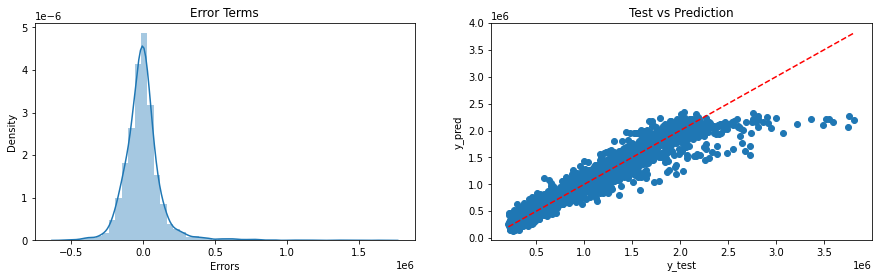

In [ ]:

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

print('The Intercept of the Regression Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)